In [38]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SVMSMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.feature_selection import SelectFromModel
import seaborn as sns



In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# import the merged studentVle_vle file 

df = pd.read_csv('studentVle_vle_info.csv')

In [4]:
#df.columns

In [5]:
#df.shape

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   code_module           object
 1   code_presentation     object
 2   id_student            int64 
 3   gender                object
 4   region                object
 5   highest_education     object
 6   imd_band              object
 7   age_band              object
 8   num_of_prev_attempts  int64 
 9   studied_credits       int64 
 10  disability            object
 11  final_result          object
 12  id_site               int64 
 13  date                  int64 
 14  sum_click             int64 
 15  activity_type         object
dtypes: int64(6), object(10)
memory usage: 1.3+ GB


In [7]:
# grouped studentVle_vle_info by activity type, retaining demographic data, the code_module and summing the clicks 
df_grouped = df.groupby(['activity_type', 'id_student', 'code_module', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']).sum('sum_click').reset_index()

In [8]:
#checking missing values
df_grouped.isnull().sum()

activity_type           0
id_student              0
code_module             0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
id_site                 0
date                    0
sum_click               0
dtype: int64

In [9]:
print(df_grouped.final_result.unique())

# check complete cases
complete_cases = df_grouped.dropna()
num_complete_cases = len(complete_cases)

print(len(df_grouped))
print(num_complete_cases)
print(len(df_grouped) - num_complete_cases)


['Pass' 'Distinction' 'Fail' 'Withdrawn']
230339
230339
0


In [10]:
# drop unneccessary columns
df_grouped.drop(['date', 'id_site', 'id_student', 'studied_credits'], axis=1, inplace=True)

#df_grouped.head()

#### PREPROCESSING

 Encoding catergorical variables

In [11]:
# use ordinal encoding to encode the variables with order categories
encoder = OrdinalEncoder()

df_grouped.imd_band = encoder.fit_transform(df_grouped[['imd_band']])
df_grouped.head()

,activity_type,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,final_result,sum_click
0,dataplus,AAA,M,Scotland,HE Qualification,8.0,55<=,0,N,Pass,21
1,dataplus,AAA,F,East Anglian Region,A Level or Equivalent,6.0,35-55,0,N,Distinction,9
2,dataplus,FFF,F,London Region,HE Qualification,2.0,35-55,0,N,Pass,35
3,dataplus,AAA,M,Yorkshire Region,Lower Than A Level,4.0,35-55,0,N,Pass,7
4,dataplus,AAA,F,Scotland,HE Qualification,2.0,35-55,0,N,Pass,10


In [12]:
# highest education and age mappings need to be defined to ensure correct ordering of values to the categories

# Define the mappings for highest education
highest_education = {'No Formal quals': 0, 'Lower Than A Level': 1, 'A Level or Equivalent': 2, 'HE Qualification': 3, 'Post Graduate Qualification': 4}
df_grouped['highest_education'] =df_grouped['highest_education'].map(highest_education)


In [13]:
# Define the mappings for age_band
age_band = {'0-35': 0, '35-55': 1, '55<=': 2}
df_grouped['age_band'] =df_grouped['age_band'].map(age_band)


In [14]:
# use sklearn OneHotEncoder to encode the variables that do not have an order to the categories 

columns_to_encode = ['activity_type','code_module', 'gender', 'region', 'disability']

data_to_encode = df_grouped[columns_to_encode]

encoder = OneHotEncoder(sparse=False)

encoded_arr = encoder.fit_transform(data_to_encode)

# all encoded columns
encoded_df = pd.DataFrame(encoded_arr, columns=encoder.get_feature_names_out())

# remove old (unencoded) columns from the original df, and add the new encoded columns 
remaining_columns = df_grouped.drop(columns_to_encode, axis=1)

df_grouped = pd.concat([remaining_columns, encoded_df], axis=1)


In [15]:
df_grouped.head()

,highest_education,imd_band,age_band,num_of_prev_attempts,final_result,sum_click,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,...,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y
0,3,8.0,2,0,Pass,21,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,6.0,1,0,Distinction,9,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,2.0,1,0,Pass,35,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,4.0,1,0,Pass,7,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,3,2.0,1,0,Pass,10,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Define the mapping for grouping final results
group_mapping = {
    'Pass': 'High Performing',
    'Distinction': 'High Performing',
    'Fail': 'Low Performing',
    'Withdrawn': 'Withdrew'
}

# Map the final results to the grouped categories and replace the original variable
df_grouped['final_result'] = df_grouped['final_result'].map(group_mapping)


In [17]:
## since the interest is not on the group that withdrew - filter out withdraw
# Filter the DataFrame to include only 'Passed' and 'Failed' groups
df_grouped = df_grouped[df_grouped['final_result'].isin(['High Performing', 'Low Performing'])]

### SPLIT THE DATA INTO TRAIN, TEST AND VALIDATION SET

In [18]:
##spliting dataset into target variable y and features X
X = df_grouped.drop(['final_result'], axis = 1)
y = df_grouped['final_result']


In [19]:
# Split the data into training and testing sets
x_train, x_remain, y_train, y_remain = train_test_split(X, y, random_state = 2, train_size=0.6)

In [20]:
x_valid, x_test, y_valid, y_test = train_test_split(x_remain, y_remain, test_size=0.5)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(109241, 49)
(109241,)
(36414, 49)
(36414,)
(36414, 49)
(36414,)


(None, None)

In [21]:
train_set = x_train.assign(final_result = y_train)

<AxesSubplot:xlabel='count', ylabel='final_result'>

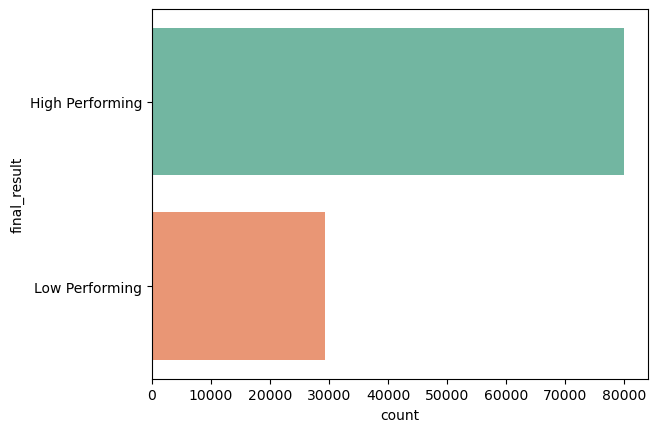

In [22]:
##visualize the training set to see if its balanced

y_variable = train_set['final_result'].value_counts().reset_index()


sns.barplot(x='count', y="final_result", data=y_variable, palette='Set2')

In [23]:
# the target variable (y) is imbalanced, with one class (e.g., 'Passed') having more instances than the other class(es).
# the models will not perfrom well on the minorit group unless we resample 
# As a result, SMOTE is chosen to create synthetic samples for the minority class(es) in order to balance the dataset.


smote = SVMSMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train.astype('float'), y_train)
print("count before SMOTE:", Counter(y_train))
print("count after SMOTE:", Counter(y_train_smote))

count before SMOTE: Counter({'High Performing': 79968, 'Low Performing': 29273})
count after SMOTE: Counter({'High Performing': 79968, 'Low Performing': 79968})


<AxesSubplot:xlabel='count', ylabel='final_result'>

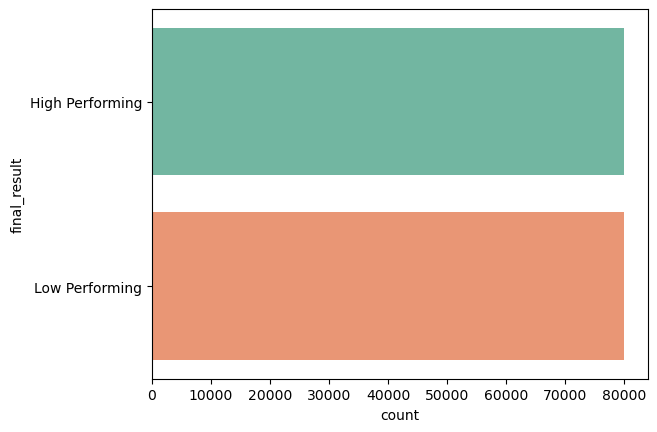

In [24]:
##visualize the dataset to see if its balanced now

y_variable2 = y_train_smote.value_counts().reset_index()
sns.barplot(x="count", y="final_result", data=y_variable2, palette='Set2')

## Feature selection
### Using random forest and feature importance 

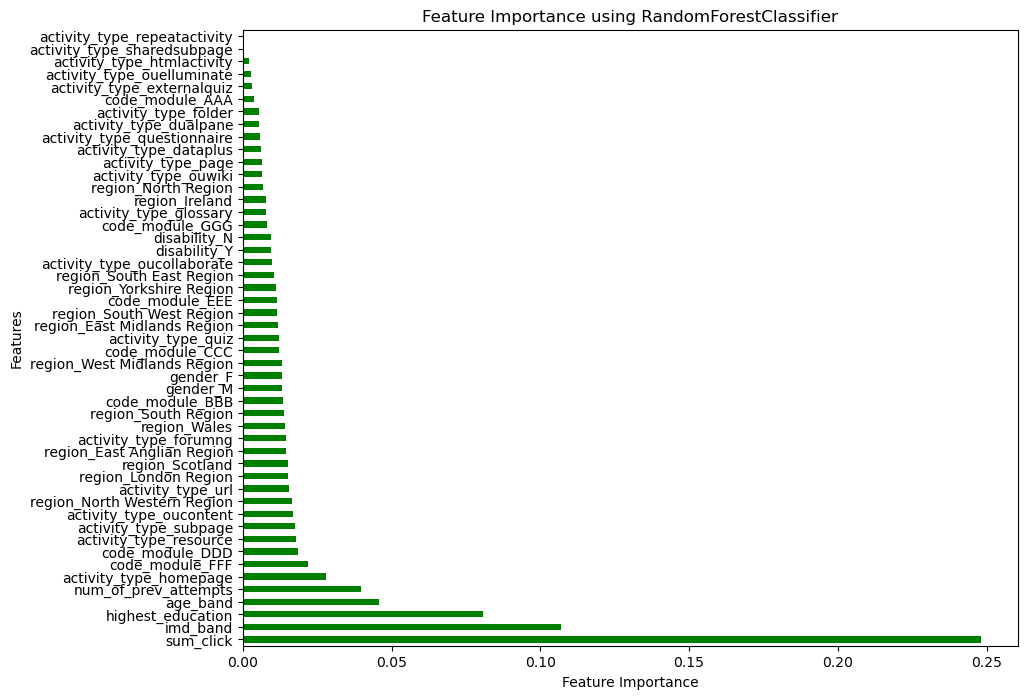

In [25]:

# train and fit the rf model
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(x_train_smote, y_train_smote)

# Get feature importances
importances = rf.feature_importances_

feature_names = [f"{i}" for i in x_train_smote] 

# Create a pandas Series with feature importances and their corresponding columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='barh', color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance using RandomForestClassifier')
plt.show()


In [136]:
#feature_importances

In [26]:
# train the selector model - use the mean value of feature importance as the cut off
selector = SelectFromModel(rf, threshold = 0.014)
selector.fit(x_train_smote, y_train_smote)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                 random_state=42),
                threshold=0.014)

In [27]:
# selects all features that have a feature importance value higher than the mean 
selected_features= x_train_smote.columns[(selector.get_support())]
print(len(selected_features))
print(selected_features)

18
Index(['highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'sum_click', 'activity_type_forumng', 'activity_type_homepage',
       'activity_type_oucontent', 'activity_type_resource',
       'activity_type_subpage', 'activity_type_url', 'code_module_DDD',
       'code_module_FFF', 'region_East Anglian Region', 'region_London Region',
       'region_North Western Region', 'region_Scotland', 'region_Wales'],
      dtype='object')


In [28]:
len(df_grouped.columns)

50

In [29]:
# create a list of the variables to be dropped - those not selected
all_features = x_train_smote.columns.append(selected_features)

series_af = pd.Series(all_features)

value_counts = series_af.value_counts()

filtered_series = series_af[series_af.isin(value_counts[value_counts == 1].index)]

filtered_list = filtered_series.tolist()

print(filtered_list)

['activity_type_dataplus', 'activity_type_dualpane', 'activity_type_externalquiz', 'activity_type_folder', 'activity_type_glossary', 'activity_type_htmlactivity', 'activity_type_oucollaborate', 'activity_type_ouelluminate', 'activity_type_ouwiki', 'activity_type_page', 'activity_type_questionnaire', 'activity_type_quiz', 'activity_type_repeatactivity', 'activity_type_sharedsubpage', 'code_module_AAA', 'code_module_BBB', 'code_module_CCC', 'code_module_EEE', 'code_module_GGG', 'gender_F', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_North Region', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_West Midlands Region', 'region_Yorkshire Region', 'disability_N', 'disability_Y']


In [30]:
# create the new training and test sets 
x_train = x_train_smote.drop(labels=filtered_list, axis=1, inplace=False)

In [31]:
x_test_allf = x_test
x_test = x_test.drop(labels=filtered_list , axis=1, inplace=False)

In [32]:
# check the sets have the correct columns 
# print(selected_features)
# print(x_train.columns)
# print(x_test.columns)

In [33]:
# re name the 
y_train = y_train_smote

In [43]:
x_valid = x_valid.drop(labels=filtered_list , axis=1, inplace=False)

In [62]:
print(sum(y_test == 'High Performing'))
print(sum(y_test == 'Low Performing'))

26751
9663


### random forest model 

In [53]:
## Randomforestclassifier

model_rf = RandomForestClassifier(n_estimators=500, random_state=10)
model_rf.fit(x_train, y_train)
y_pred_model = model_rf.predict(x_test)


Classification Report:
                 precision    recall  f1-score   support

High Performing       0.80      0.86      0.83     26751
 Low Performing       0.51      0.41      0.45      9663

       accuracy                           0.74     36414
      macro avg       0.66      0.63      0.64     36414
   weighted avg       0.72      0.74      0.73     36414



Text(0.5, 1.0, 'Confusion Matrix showing the percentage of test data in each group')

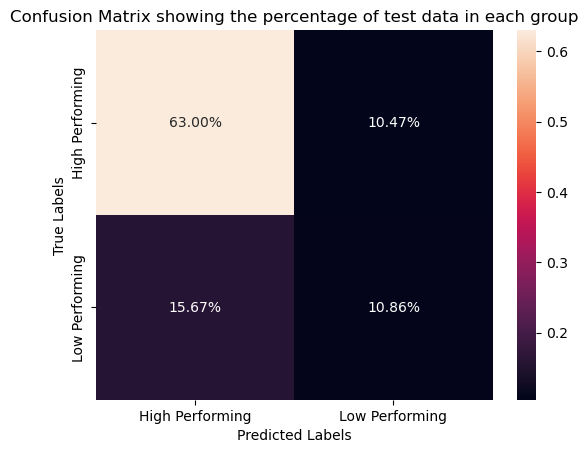

In [63]:
print('Classification Report:')
print(classification_report(y_test, y_pred_model))

# Summarize the performance of the model using confusion matrix

model_cm = confusion_matrix(y_test, y_pred_model)


# show the lables and the percentages of the groups 

classes = ['High Performing', 'Low Performing']

#print(model_cm)
sns.heatmap(model_cm/np.sum(model_cm), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix showing the percentage of test data in each group')

In [65]:
model_cm

5707/9663

0.5906033322984581

### DT


In [40]:
tree_mod = DecisionTreeClassifier(random_state=0)
tree_mod.fit(x_train, y_train)

y_predictions = tree_mod.predict(x_test)

Classification Report:
                 precision    recall  f1-score   support

High Performing       0.79      0.80      0.80     26751
 Low Performing       0.43      0.41      0.42      9663

       accuracy                           0.70     36414
      macro avg       0.61      0.61      0.61     36414
   weighted avg       0.69      0.70      0.70     36414



Text(0.5, 1.0, 'Confusion Matrix showing the percentage of test data in each group')

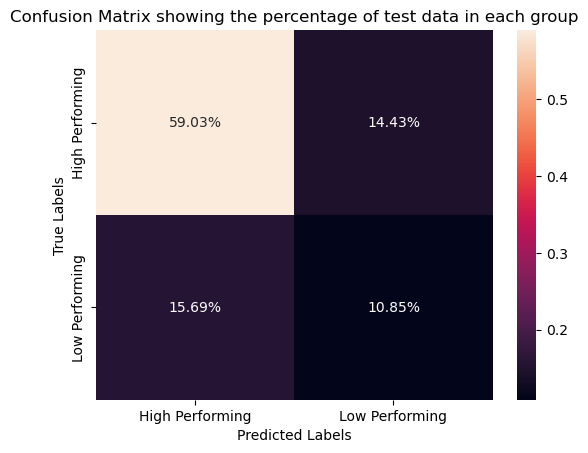

In [41]:
print('Classification Report:')
print(classification_report(y_test, y_predictions))

# Summarize the performance of the model using confusion matrix

tree_cm = confusion_matrix(y_test, y_predictions)

classes = ['High Performing', 'Low Performing']

sns.heatmap(tree_cm/np.sum(tree_cm), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix showing the percentage of test data in each group')

### Scaling the data

In [34]:
# fit scaler on training data
norm = MinMaxScaler().fit(x_train)

# scale the train and test sets
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)
#x_val_norm = norm.transform(x_valid)

In [35]:
x_train_norm = pd.DataFrame(x_train_norm, columns=x_train.columns)
x_test_norm = pd.DataFrame(x_test_norm, columns=x_test.columns)

### KNN

In [59]:
clf = KNeighborsClassifier(n_neighbors = 25)
clf.fit(x_train_norm, y_train)

y_pred = clf.predict(x_test_norm)
 

Classification Report:
                 precision    recall  f1-score   support

High Performing       0.79      0.85      0.82     26751
 Low Performing       0.46      0.36      0.40      9663

       accuracy                           0.72     36414
      macro avg       0.62      0.60      0.61     36414
   weighted avg       0.70      0.72      0.71     36414



Text(0.5, 1.0, 'Confusion Matrix showing the percentage of test data in each group')

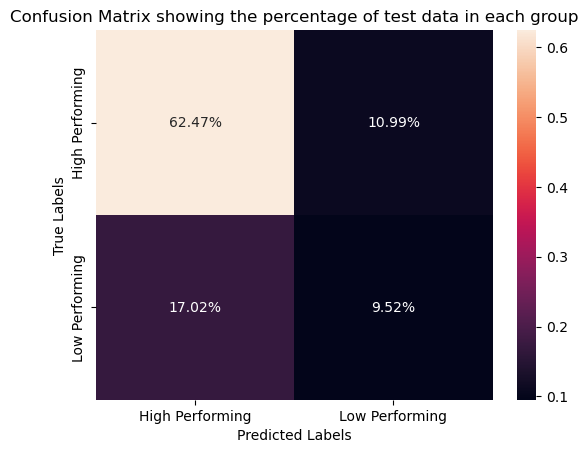

In [60]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

knn_cm = confusion_matrix(y_test, y_pred)

classes = ['High Performing', 'Low Performing']

sns.heatmap(knn_cm/np.sum(knn_cm), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix showing the percentage of test data in each group')


Used Random Forest model for validation as it produced precision and accuracy scores out of all the models tested

### Validation

Classification Report:
                 precision    recall  f1-score   support

High Performing       0.80      0.86      0.83     26814
 Low Performing       0.52      0.41      0.46      9600

       accuracy                           0.75     36414
      macro avg       0.66      0.64      0.65     36414
   weighted avg       0.73      0.75      0.74     36414



Text(0.5, 1.0, 'Confusion Matrix showing the percentage of test data in each group')

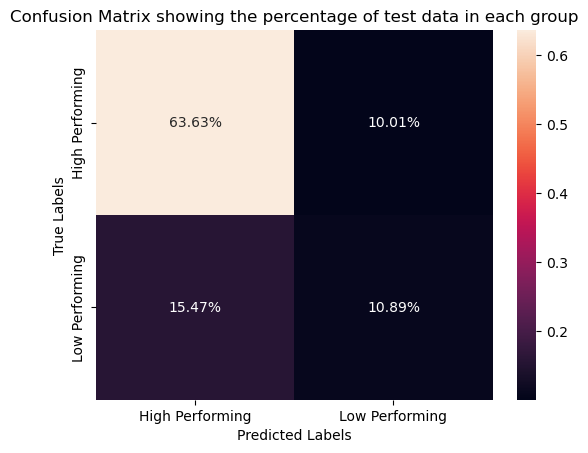

In [56]:
valid_pred = model_rf.predict(x_valid)
print('Classification Report:')
print(classification_report(y_valid, valid_pred))


v_rf_cm = confusion_matrix(y_valid, valid_pred)


# show the lables and the percentages of the groups 

classes = ['High Performing', 'Low Performing']

sns.heatmap(v_rf_cm/np.sum(v_rf_cm), annot=True, fmt='.2%', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix showing the percentage of test data in each group')